In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
import pickle

In [50]:
curr_dir = !pwd
pfam_version = "31"

hhalign_scores = pd.read_csv(curr_dir[0]+"/pfam-v"+pfam_version+"/domains_hhlign_scores.csv", sep='\t', index_col=0)

### Remove domains from "no clan" that were accidentally calculated (now it's removed before running hhalign, but keeping this here for pfam-v30)

In [51]:
#Remove domains from "no clan" that were accidentally calculated
clan_path = curr_dir[0]+"/../../2.parse_Pfam/v"+pfam_version+"/"
with open(clan_path+"domain_to_clan_dict.pik", 'rb') as handle:
    domain_to_clan_dict = pickle.load(handle)
with open(clan_path+"clan_to_domains_dict.pik", 'rb') as handle:
    clan_to_domains_dict = pickle.load(handle)

In [52]:
drop_idx = []
for index, row in hhalign_scores.iterrows():
    clan1 = domain_to_clan_dict[row["sim_dom1"]]
    clan2 = domain_to_clan_dict[row["sim_dom2"]]
    if (clan1 == "No_clan" and clan2 == "No_clan"):
        drop_idx.append(index)

In [53]:
len(drop_idx)

0

In [54]:
hhalign_scores_filtered_no_clan = hhalign_scores.drop(drop_idx)
hhalign_scores_filtered_no_clan = hhalign_scores_filtered_no_clan.reset_index(drop=True)

In [56]:
hhalign_scores_filtered_no_clan.columns

Index([u'index', u'sim_dom1', u'sim_dom2', u'prob1', u'pval1', u'score1',
       u'aligned_cols1', u'prob2', u'pval2', u'score2', u'ident_perc2',
       u'ident_perc1', u'aligned_cols2'],
      dtype='object')

### Adding the raw score divided by cols aligned
from the HHsuite userguise: https://github.com/soedinglab/hh-suite/blob/master/hhsuite-userguide.pdf (page 23):

How can I build a phylogenetic tree for HMMs? I would use a similarity measure like
the raw score per alignment length. You might also add the secondary structure score to the
raw score with some weight. Whereas probabilities, E-values, and P-values are useful for deciding
whether a match is a reliable homolog or not, they are not suitable for measuring similarities
because they strongly depend on the length of the alignment

In [58]:
score_alignment_cols_ratio_list1 = []
score_alignment_cols_ratio_list2 = []
for index, row in hhalign_scores_filtered_no_clan.iterrows():
    score_norm = row["score1"]/float(row["aligned_cols1"])
    score_alignment_cols_ratio_list1.append(score_norm)
    score_norm = row["score2"]/float(row["aligned_cols2"])
    score_alignment_cols_ratio_list2.append(score_norm)

hhalign_scores_filtered_no_clan["score_norm1"] = score_alignment_cols_ratio_list1
hhalign_scores_filtered_no_clan["score_norm2"] = score_alignment_cols_ratio_list2

### Check the scores distribution to determine a threshold for similarity

In [9]:
h = np.histogram(hhalign_scores_filtered_no_clan["scores"])

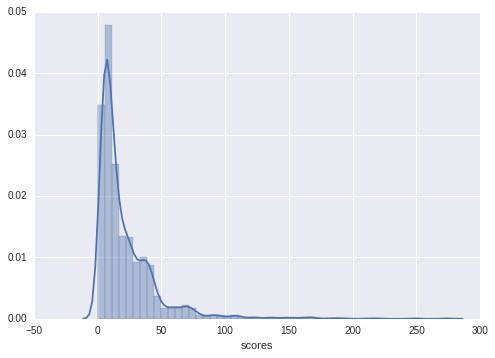

In [10]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))
sns.distplot(hhalign_scores_filtered_no_clan["scores"]);

This distribution is only of similarity scores within clans, so they are already pretty high and not represnting similarity between two random domains.

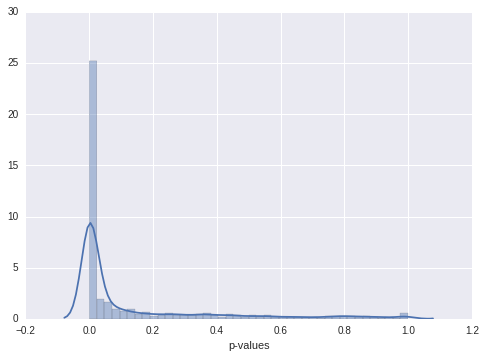

In [12]:
sns.distplot(hhalign_scores_filtered_no_clan["p-values"]);

0.001 p-value is the diffault threshold for Viterbi:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3197634/

In [40]:
np.sum(hhalign_scores_filtered_no_clan["p-values"] <= 0.001)

877

In [71]:
#Has both directions with meaningful alignments
significantly_similar_pairs1 = hhalign_scores_filtered_no_clan[hhalign_scores_filtered_no_clan["aligned_cols1"] >= 10][hhalign_scores_filtered_no_clan["pval1"] <= 0.001]
significantly_similar_pairs2 = hhalign_scores_filtered_no_clan[hhalign_scores_filtered_no_clan["aligned_cols2"] >= 10][hhalign_scores_filtered_no_clan["pval2"] <= 0.001]

In [79]:
#Finding the intersection
significantly_similar_pairs = pd.merge(significantly_similar_pairs1, significantly_similar_pairs2, how="inner")

In [81]:
#Saving to .csv
significantly_similar_pairs.to_csv("pfam-v"+pfam_version+"/sig_pairs_pvals0.001_cols10_2directions.csv", sep='\t')

#### Checking one domain for exmaple

In [84]:
pd.DataFrame.append(significantly_similar_pairs[significantly_similar_pairs["sim_dom1"] == "Sulfotransfer_2"], significantly_similar_pairs[significantly_similar_pairs["sim_dom2"] == "Sulfotransfer_2"])

,index,sim_dom1,sim_dom2,prob1,pval1,score1,aligned_cols1,prob2,pval2,score2,ident_perc2,ident_perc1,aligned_cols2,score_norm1,score_norm2
85,2993,Sulfotransfer_2,Sulfotransfer_3,65.27,2.900000e-04,26.50,24,71.46,1.800000e-04,27.16,13,13,24,1.104167,1.131667
86,2995,Sulfotransfer_2,Sulfotransfer_1,97.32,5.200000e-09,52.55,25,97.31,6.600000e-09,50.01,16,16,25,2.102000,2.000400


### Draft - old condition on raw score
According the HHalign userguide raw score is dependant on length, score should be normalized by number of aligned columns.

HHalign Viterbi score >= 11 like the threshold used in: https://academic.oup.com/nar/article/45/W1/W470/3782606

In [34]:
significantly_similar_pairs = hhalign_scores_filtered_no_clan[hhalign_scores_filtered_no_clan["p-values"] <= 0.001][hhalign_scores_filtered_no_clan["scores"] >= 10]
significantly_similar_pairs.reset_index(inplace=True, drop=True)